In [9]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations
import random

In [249]:
phase_dirs = ['../phased_ssc.hg38', '../phased_mssng_quads', '../phased_ihart.ms2_quads']
assembly = '38'

In [250]:
child_to_crossovers = defaultdict(list)
for phase_dir in phase_dirs:
    print(phase_dir)
    for file in sorted(os.listdir(phase_dir)):
        if file.endswith('.crossovers.json'):
            with open('%s/%s' % (phase_dir, file), 'r') as f:
                cos = json.load(f)
                if len(cos)<250:
                    for co in cos:
                        child_to_crossovers[tuple(co['child'])].append(co)
                else:
                    print('Are they related?', file)
    print(len(child_to_crossovers))
            
print(len(child_to_crossovers))

../phased_ssc.hg38
Are they related? 12970.crossovers.json
Are they related? 13949.crossovers.json
Are they related? 13976.crossovers.json
Are they related? 14357.crossovers.json
Are they related? 14655.crossovers.json
1921
../phased_mssng_quads
2657
../phased_ihart.ms2_quads
Are they related? AU0832.AU083203.AU083204.crossovers.json
Are they related? AU0866.AU0866301.AU0866302.crossovers.json
Are they related? AU0905.AU0905301.AU0905302.crossovers.json
Are they related? AU0905.AU0905301.AU0905303.crossovers.json
Are they related? AU0923.AU0923301.AU0923302.crossovers.json
Are they related? AU0941.AU0941301.AU0941302.crossovers.json
Are they related? AU0951.AU0951301.AU0951302.crossovers.json
Are they related? AU1497.AU1497301.AU1497302.crossovers.json
Are they related? AU1497.AU1497301.AU1497303.crossovers.json
Are they related? AU1822.AU1822301.AU1822302.crossovers.json
4586
4586


In [251]:
subtel_regions = []
with open('../data/telomere%s.bed' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:].isnumeric():
            subtel_regions.append((int(pieces[0][3:]), int(pieces[1]), int(pieces[2])))
            
tel_regions = []
with open('../data/gap%s.txt' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1][3:].isnumeric() and pieces[7] == 'telomere':
            #tel_regions.append((int(pieces[0][3:]), int(pieces[1]), int(pieces[2])))
            tel_regions.append((int(pieces[1][3:]), int(pieces[2]), int(pieces[3])))
print(len(subtel_regions), len(tel_regions))

41 44


In [252]:
tel_adjacent_mat = []
tel_adjacent_pat = []
for chrom, start_pos, end_pos in tel_regions:
    print(chrom, start_pos, end_pos)
    if start_pos == 0:
        start_pos = end_pos
        end_pos = start_pos + 500000
        is_start = True
    else:
        end_pos = start_pos
        start_pos = end_pos - 500000
        is_start = False

    recomb_mat_detailed = np.zeros((end_pos-start_pos,))
    recomb_pat_detailed = np.zeros((end_pos-start_pos,))

    already_included = set()
    for child, crossovers in child_to_crossovers.items():
        if child[0] not in already_included and child[1] not in already_included:
            for co in crossovers:
                if (co['chrom'] == chrom) and (min(end_pos, co['end_pos'])-max(start_pos, co['start_pos'])>0):
                    if co['is_mat']:
                        start_index, end_index = np.clip(co['start_pos']-start_pos, 0, end_pos-start_pos), np.clip(co['end_pos']-start_pos, 0, end_pos-start_pos)
                        recomb_mat_detailed[start_index:end_index] += (1/(co['end_pos']-co['start_pos']))
                    if co['is_pat']:
                        start_index, end_index = np.clip(co['start_pos']-start_pos, 0, end_pos-start_pos), np.clip(co['end_pos']-start_pos, 0, end_pos-start_pos)
                        recomb_pat_detailed[start_index:end_index] += (1/(co['end_pos']-co['start_pos']))
            already_included.add(child[0])
            already_included.add(child[1])

    if is_start:
        tel_adjacent_mat.append(recomb_mat_detailed/len(already_included))
        tel_adjacent_pat.append(recomb_pat_detailed/len(already_included))
    else:
        tel_adjacent_mat.append(np.flip(recomb_mat_detailed/len(already_included)))
        tel_adjacent_pat.append(np.flip(recomb_pat_detailed/len(already_included)))

print(len(already_included))

1 0 10000
1 248946422 248956422
2 0 10000
2 242183529 242193529
3 0 10000
3 198285559 198295559
4 0 10000
4 190204555 190214555
5 0 10000
5 181528259 181538259
6 0 10000
6 170795979 170805979
7 0 10000
7 159335973 159345973
8 0 10000
8 145128636 145138636
9 0 10000
9 138384717 138394717
10 0 10000
10 133787422 133797422
11 0 10000
11 135076622 135086622
12 0 10000
12 133265309 133275309
13 0 10000
13 114354328 114364328
14 0 10000
14 107033718 107043718
15 0 10000
15 101981189 101991189
16 0 10000
16 90328345 90338345
17 0 10000
17 83247441 83257441
18 0 10000
18 80363285 80373285
19 0 10000
19 58607616 58617616
20 0 10000
20 64434167 64444167
21 0 10000
21 46699983 46709983
22 0 10000
22 50808468 50818468
6492


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10


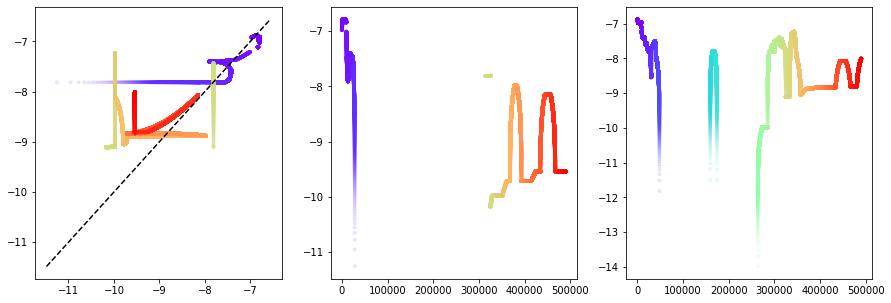

In [293]:
import matplotlib.cm as cm

i = 23
smooth_factor = 10000

c = np.cumsum(tel_adjacent_mat[i])
mat = (c[smooth_factor:]-c[:-smooth_factor])/smooth_factor
c = np.cumsum(tel_adjacent_pat[i])
pat = (c[smooth_factor:]-c[:-smooth_factor])/smooth_factor

colors = cm.rainbow(np.linspace(0, 1, len(mat)))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(np.log10(mat), np.log10(pat), color=colors, marker='.', alpha=0.1)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.scatter(np.arange(0, len(mat)), np.log10(mat), color=colors, marker='.', alpha=0.1)

plt.subplot(1, 3, 3)
plt.scatter(np.arange(0, len(pat)), np.log10(pat), color=colors, marker='.', alpha=0.1)

plt.show()

78169 78170
8878 8900
382369 382371
5139 5140
29637 29637
115813 115813
5363 5389
174770 174770
2130 2130
79613 79627
111394 111394
56207 56207
13794 13795
766 767
85135 85149


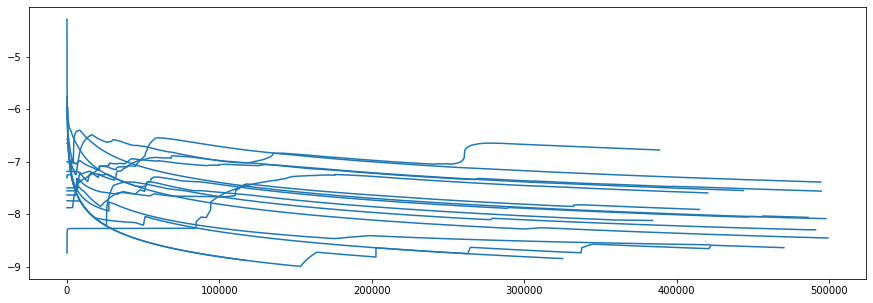

In [279]:
smooth_factor = 10000
plt.figure(figsize=(15, 5))
for i in range(15):
    c = np.cumsum(tel_adjacent_mat[i])
    diff = c[1:]-c[:-1]
    offset = np.argmax(c>0)
    end_offset = np.argmax(diff[1:]-diff[:-1]<0)
    print(offset, end_offset)
    plt.plot(np.log10(c[offset:]/np.arange(1, len(c)-offset+1)), color=p[0].get_color())
plt.show()

In [258]:
smooth_factor = 10000
tel_adjacent_mat_smoothed = np.zeros((len(tel_adjacent_mat), tel_adjacent_mat[0].shape[0]-smooth_factor))
for i, tm in enumerate(tel_adjacent_mat):
    c = np.cumsum(tm)
    #offset = np.argmax(tel_adjacent_pat[i]>0)
    tel_adjacent_mat_smoothed[i, :] = (c[smooth_factor:]-c[:-smooth_factor])/smooth_factor
    #if offset == 0:
    #    tel_adjacent_mat_smoothed[i, :] = c/np.arange(1, len(c)+1)
    #else:
    #    tel_adjacent_mat_smoothed[i, :-offset] = c[offset:]/np.arange(1, len(c)-offset+1)
    
tel_adjacent_pat_smoothed = np.zeros((len(tel_adjacent_pat), tel_adjacent_pat[0].shape[0]-smooth_factor))
for i, tm in enumerate(tel_adjacent_pat):
    c = np.cumsum(tm)
    #offset = np.argmax(tel_adjacent_pat[i]>0)
    tel_adjacent_pat_smoothed[i, :] = (c[smooth_factor:]-c[:-smooth_factor])/smooth_factor
    #if offset == 0:
    #    tel_adjacent_pat_smoothed[i, :] = c/np.arange(1, len(c)+1)
    #else:
    #    tel_adjacent_pat_smoothed[i, :-offset] = c[offset:]/np.arange(1, len(c)-offset+1)
    
    

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


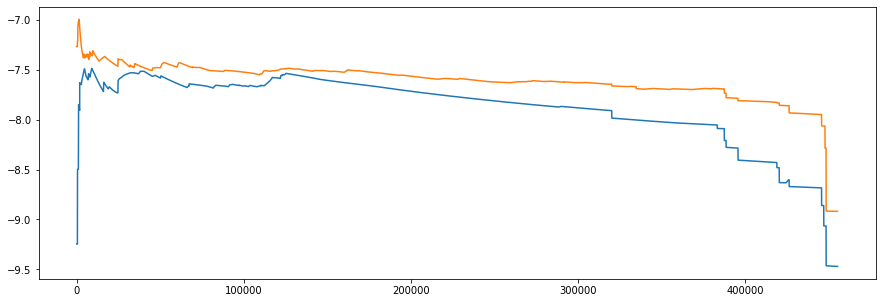

In [254]:
plt.figure(figsize=(15, 5))

plt.plot(np.log10(np.quantile(tel_adjacent_mat_smoothed, 0.5, axis=0)))
plt.plot(np.log10(np.quantile(tel_adjacent_pat_smoothed, 0.5, axis=0)))
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


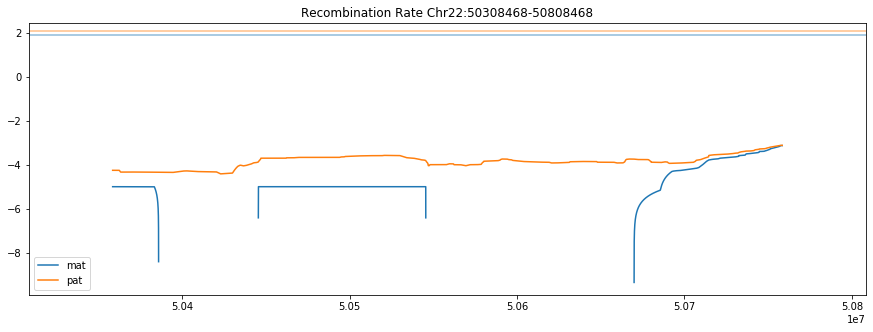

In [259]:
smooth_factor = 100000

plt.figure(figsize=(15, 5))
#p = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_mat_detailed), label='ihart+ssc+mssng mat', alpha=0.2)
c = np.cumsum(recomb_mat_detailed)
p = plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)), np.log10((c[smooth_factor:]-c[:-smooth_factor])/smooth_factor), 
                        label='mat')
#q = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_pat_detailed), label='ihart+ssc+mssng pat', alpha=0.2)
c = np.cumsum(recomb_pat_detailed)
q = plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)), np.log10((c[smooth_factor:]-c[:-smooth_factor])/smooth_factor), 
                        label='pat')

plt.axhline(np.log10(np.sum(recomb_mat_detailed)), color=p[0].get_color(), alpha=0.5)
plt.axhline(np.log10(np.sum(recomb_pat_detailed)), color=q[0].get_color(), alpha=0.5)
plt.xlim([start_pos, end_pos])
plt.legend()

for ch, s, e in tel_regions:
    if chrom==ch and min(e, end_pos)-max(s, start_pos)>0:
        plt.plot([s, e], [-10, -10], linewidth=10)

#if start_pos==0:
#    plt.xlim([0, 1000000])
#else:
#    plt.xlim([end_pos-1000000, end_pos])

plt.title('Recombination Rate Chr%d:%d-%d' % (chrom, start_pos, end_pos))
plt.show()
